In [1]:
! pip install kaggle

In [3]:
! pip install tensorflow keras

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download iroldan/real-doppler-raddar-database

 77% 49.0M/63.6M [00:00<00:00, 117MB/s] 
100% 63.6M/63.6M [00:00<00:00, 116MB/s]


In [8]:
! unzip real-doppler-raddar-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/People/11-23f/015.csv  
  inflating: data/People/11-23f/016.csv  
  inflating: data/People/11-23f/017.csv  
  inflating: data/People/11-23f/018.csv  
  inflating: data/People/11-23f/019.csv  
  inflating: data/People/11-23f/020.csv  
  inflating: data/People/11-23f/021.csv  
  inflating: data/People/11-23f/022.csv  
  inflating: data/People/11-23f/023.csv  
  inflating: data/People/11-23f/024.csv  
  inflating: data/People/11-23f/025.csv  
  inflating: data/People/11-23f/026.csv  
  inflating: data/People/11-23f/027.csv  
  inflating: data/People/11-23f/028.csv  
  inflating: data/People/11-23f/029.csv  
  inflating: data/People/11-23f/030.csv  
  inflating: data/People/11-23f/031.csv  
  inflating: data/People/11-23f/032.csv  
  inflating: data/People/11-23f/033.csv  
  inflating: data/People/11-23f/034.csv  
  inflating: data/People/11-23f/035.csv  
  inflating: data/People/11-23f/036.csv  
  inflating: data/People/

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model

DIR = 'data'
CLASS = {'Cars': 0, 'Drones': 1, 'People': 2}

list_of_file = []
list_of_img = []
list_of_classi = []

for root, dirs, files in os.walk(DIR):
    for file in files:
        if file.endswith('.csv'):
            tmp = root.strip().split('/')
            if tmp[-2] in CLASS:
                list_of_classi.append(CLASS[tmp[-2]])
                list_of_file.append(os.path.join('/'.join(tmp[-3:]), file))
                df = pd.read_csv(os.path.join(root, file), sep=',', header=None)
                list_of_img.append(df.values)

x = np.array(list_of_img)
y = np.array(list_of_classi)
d = np.array(list_of_file)

print(len(list_of_file), 'files loaded.')



17485 files loaded.


In [10]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def get_similar_pairs(x, y):
    pairs = []
    labels = []
    for i in range(len(x)):
        indices = np.where(y == y[i])[0]
        j = np.random.choice(indices)
        pairs.append([x[i], x[j]])
        labels.append(1)
    return np.array(pairs), np.array(labels)

def get_dissimilar_pairs(x, y):
    pairs = []
    labels = []
    for i in range(len(x)):
        indices = np.where(y != y[i])[0]
        j = np.random.choice(indices)
        pairs.append([x[i], x[j]])
        labels.append(0)
    return np.array(pairs), np.array(labels)


x_train_pairs_similar, y_train_pairs_similar = get_similar_pairs(x_train, y_train)
x_train_pairs_dissimilar, y_train_pairs_dissimilar = get_dissimilar_pairs(x_train, y_train)
x_test_pairs_similar, y_test_pairs_similar = get_similar_pairs(x_test, y_test)
x_test_pairs_dissimilar, y_test_pairs_dissimilar = get_dissimilar_pairs(x_test, y_test)

x_train_pairs = np.concatenate([x_train_pairs_similar, x_train_pairs_dissimilar], axis=0)
y_train_pairs = np.concatenate([y_train_pairs_similar, y_train_pairs_dissimilar], axis=0)
x_test_pairs = np.concatenate([x_test_pairs_similar, x_test_pairs_dissimilar], axis=0)
y_test_pairs = np.concatenate([y_test_pairs_similar, y_test_pairs_dissimilar], axis=0)

In [12]:


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [13]:

def show_image(image):
    plt.figure()
    plt.imshow(image,cmap='hot')
    plt.colorbar()
    plt.grid(True)
    plt.show()

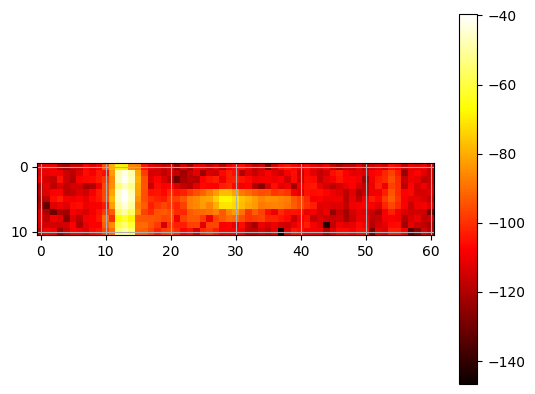

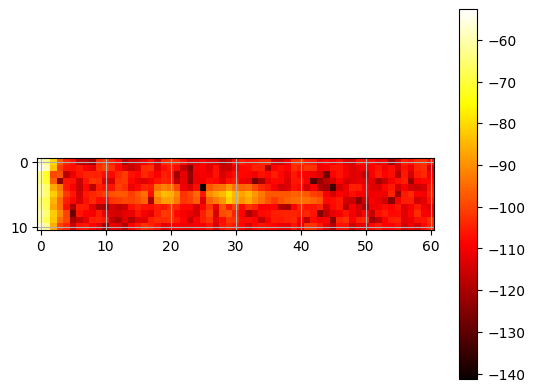

1


In [14]:
# array index
this_pair = 100

# show images at this index
show_image(x_test_pairs[1000][0])
show_image(x_test_pairs[7][1])

# print the label for this pair
print(y_test_pairs[this_pair])

In [15]:
def create_siamese_model():
    input = Input(shape=(11,61,))
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)
    output = Dense(16, activation="sigmoid")(x)
    model = Model(inputs=input, outputs=output)
    return model


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

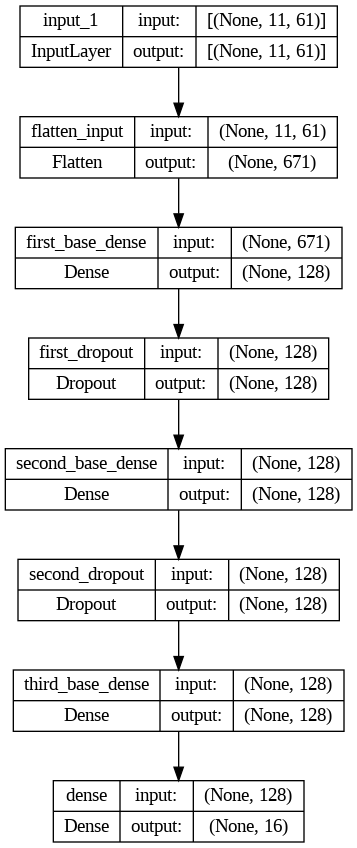

In [16]:
base_network = create_siamese_model()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

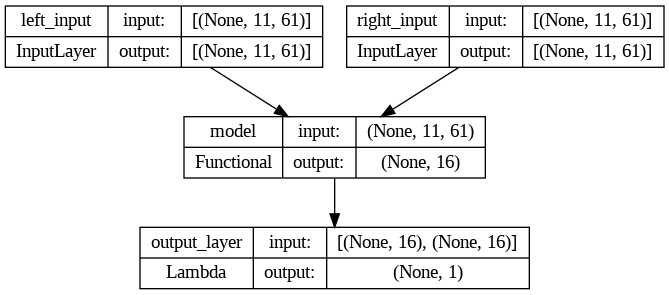

In [18]:
# left input
input_a = Input(shape=(11,61,), name="left_input")
vect_output_a = base_network(input_a)

# right input
input_b = Input(shape=(11,61,), name="right_input")
vect_output_b = base_network(input_b)

# measuring distance
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
model = Model([input_a, input_b], output)

plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [19]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        y_true = K.cast(y_true, dtype='float32')
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [21]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms, metrics=['accuracy'], run_eagerly=True)
history = model.fit([x_train_pairs[:,0], x_train_pairs[:,1]], y_train_pairs, epochs=20, batch_size=128, validation_data=([x_test_pairs[:,0], x_test_pairs[:,1]], y_test_pairs))

Epoch 1/20
219/219 [==============================] - 9s 43ms/step - loss: 0.4996 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 2/20
219/219 [==============================] - 9s 42ms/step - loss: 0.4996 - accuracy: 0.4999 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 3/20
219/219 [==============================] - 10s 44ms/step - loss: 0.4996 - accuracy: 0.4999 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 4/20
219/219 [==============================] - 10s 45ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 5/20
219/219 [==============================] - 9s 43ms/step - loss: 0.4996 - accuracy: 0.4999 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 6/20
219/219 [==============================] - 11s 48ms/step - loss: 0.4995 - accuracy: 0.4999 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 7/20
219/219 [==============================] - 10s 45ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.

In [22]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [23]:
loss = model.evaluate(x=[x_test_pairs[:,0],x_test_pairs[:,1]], y=y_test_pairs)

y_pred_train = model.predict([x_train_pairs[:,0], x_train_pairs[:,1]])
train_accuracy = compute_accuracy(y_train_pairs, y_pred_train)

y_pred_test = model.predict([x_test_pairs[:,0], x_test_pairs[:,1]])
test_accuracy = compute_accuracy(y_test_pairs, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

219/219 [==============================] - 2s 7ms/step
Loss = [0.4996834993362427, 0.5], Train Accuracy = 0.5 Test Accuracy = 0.5


In [24]:
embeddings = model.predict([x_train_pairs[:,0], x_train_pairs[:,1]])

875/875 [==============================] - 7s 8ms/step


In [25]:
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (27976, 1)


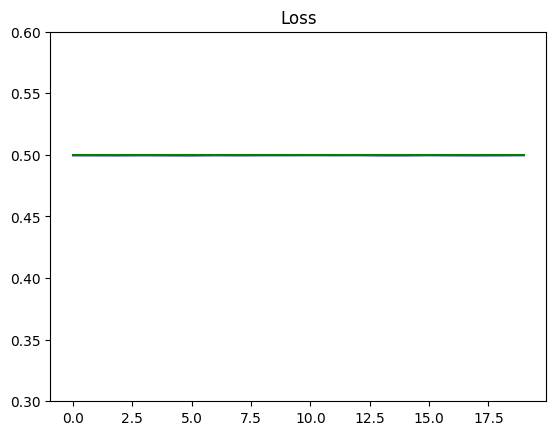

In [26]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0.3,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.6)

In [27]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 11, 61])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [11, 61*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([61*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)

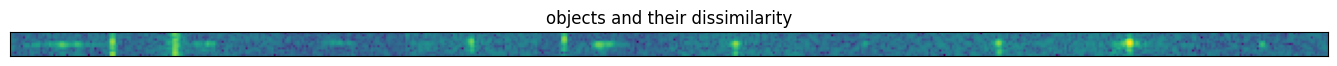

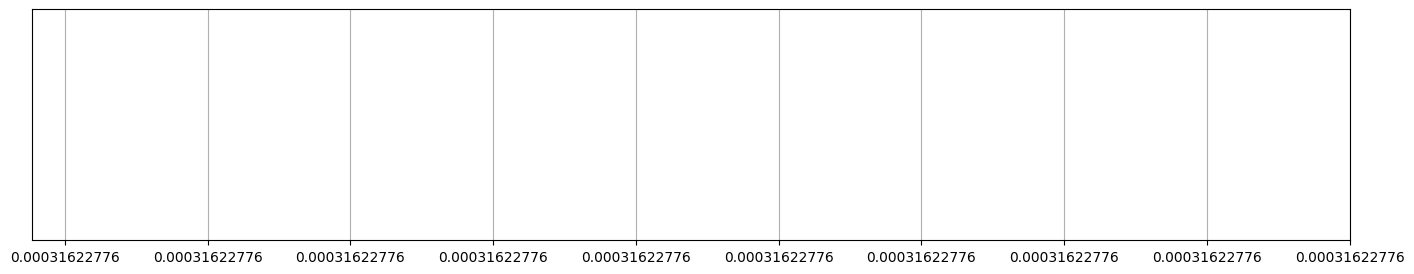

In [28]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(x_train_pairs[:, 0][indexes], x_train_pairs[:, 1][indexes], y_pred_train[indexes], y_train_pairs[indexes], "objects and their dissimilarity", 10)

In [ ]:
#@title
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels)
plt.show()

ValueError: ignored